# Back-and-Forth stepsize sweep
This notebook mirrors the Gaussian mixture pipeline used in `notebooks/back_and_forth.ipynb` and extends it to study how different step sizes change the behavior of the Back-and-Forth (BFM) solver. It builds identical 1D/2D problem generators, sweeps several step sizes, and visualizes convergence together with pushforward distributions.


In [1]:
import sys, os, time
from jax import config

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
os.environ['JAX_PLATFORM_NAME'] = 'cpu'     # change to 'gpu' or 'tpu' if needed
config.update("jax_enable_x64", True)
sys.path.insert(0, os.path.abspath(os.path.join("..")))

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from uot.problems.generators import GaussianMixtureGenerator
from uot.utils.costs import cost_euclid_squared
from uot.experiments.runner import run_pipeline
from uot.experiments.experiment import Experiment
from uot.problems.iterator import OnlineProblemIterator
from uot.solvers.solver_config import SolverConfig

from uot.solvers.back_and_forth import BackNForthSqEuclideanSolver
from uot.solvers.back_and_forth.pushforward import adaptive_pushforward_nd
from uot.solvers.back_and_forth.method import backnforth_sqeuclidean_nd
from uot.solvers.back_and_forth.monge_map import monge_map_from_psi_nd
from uot.utils.metrics.pushforward_map_metrics import extra_grid_metrics


In [71]:
import plotly.io as pio

pub_template = dict(
    layout=go.Layout(
        font=dict(
            family="Latin Modern",
            # family="Times New Roman",
            size=14
        ),
        legend=dict(
            borderwidth=0,
            font=dict(size=11),
        ),
        margin=dict(l=20, r=20, t=30, b=10),
        xaxis=dict(
            ticks="outside",
            ticklen=6,
            tickwidth=1.5,
            tickcolor="black",
            showline=True,
            linewidth=0.8,
            linecolor="black",
            # mirror=True,
            ticklabelposition="outside",
            ticklabelstandoff=5,
        ),
        yaxis=dict(
            ticks="outside",
            ticklen=6,
            tickwidth=1.5,
            tickcolor="black",
            showline=True,
            linewidth=0.8,
            linecolor="black",
            # mirror=True,
            ticklabelposition="outside",
            ticklabelstandoff=5,
        ),
    )
)
pio.templates["publication"] = pub_template
pio.templates.default = "plotly_white+publication"
# pio.templates.default = "plotly_white"

# switch to statis 'png' for presenting figures
pio.renderers.default = "png"
# use 'notebook' for jupyter notebook
# pio.renderers.default = "vscode"
# pio.renderers.default = "notebook"

In [3]:
from uot.utils.logging import logger as root_logger
root_logger.setLevel("WARNING")
from uot.problems.iterator import logger as iterator_logger
iterator_logger.setLevel("WARNING")


In [4]:

def _grid_coords_from_axes(axes):
    return jnp.stack(jnp.meshgrid(*axes, indexing="ij"), axis=-1)


def _monge_map_index_to_physical(monge_map, axes):
    arr = jnp.asarray(monge_map)
    spatial_shape = tuple(len(ax) for ax in axes)
    d = len(spatial_shape)
    if arr.ndim == len(spatial_shape):
        arr = arr[..., None]
    if arr.shape[0] == d and arr.ndim == len(spatial_shape) + 1:
        arr = jnp.moveaxis(arr, 0, -1)
    elif arr.shape[-1] != d:
        arr = arr.reshape(spatial_shape + (d,))
    spacings = jnp.array([
        float(ax[1] - ax[0]) if ax.shape[0] > 1 else 1.0 for ax in axes
    ], dtype=arr.dtype)
    origins = jnp.array([float(ax[0]) for ax in axes], dtype=arr.dtype)
    reshape = (1,) * len(spatial_shape) + (d,)
    return origins.reshape(reshape) + arr * spacings.reshape(reshape)


def _sort_curve(x, *ys):
    order = np.argsort(x)
    sorted_x = np.asarray(x)[order]
    sorted_arrays = [np.asarray(arr)[order] for arr in ys]
    return sorted_x, sorted_arrays


monge_metric_columns = [
    "tv_mu_to_nu",
    "ma_residual_L1",
    "ma_residual_Linf",
    "detJ_min",
    "detJ_max",
    "detJ_neg_frac",
    "phi_is_convex",
]
performance_columns = [
    "iterations",
    "error",
    "marginal_error_L2",
    "runtime",
    "cost",
]
DEFAULT_STEPSIZE_COLORS = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


def _stepsize_color_map(values, palette=None):
    palette = palette or DEFAULT_STEPSIZE_COLORS
    unique = sorted({float(val) for val in values})
    return {
        step: palette[idx % len(palette)]
        for idx, step in enumerate(unique)
    }



In [5]:
def solve_fn(problem, solver_instance, measures, costs, *args, **kwargs):
    start = time.perf_counter()
    results = solver_instance.solve(
        marginals=measures,
        costs=costs,
        *args,
        **kwargs,
    )
    stop = time.perf_counter()
    results["runtime"] = stop - start

    mu_measure, nu_measure = measures
    axes_mu, mu_nd = mu_measure.for_grid_solver(backend="jax", dtype=jnp.float64)
    _, nu_nd = nu_measure.for_grid_solver(backend="jax", dtype=jnp.float64)

    psi = jnp.asarray(results["v_final"]).reshape(mu_nd.shape)
    pushforward_fn = getattr(solver_instance, "_pushforward_fn", adaptive_pushforward_nd)
    pushforward_mu, _ = pushforward_fn(mu_nd, -psi)

    T_phys = _monge_map_index_to_physical(results["monge_map"], axes_mu)
    X = _grid_coords_from_axes(axes_mu)

    monge_metrics = extra_grid_metrics(
        mu_nd=mu_nd,
        nu_nd=nu_nd,
        axes_mu=axes_mu,
        X=X,
        T=T_phys,
        pushforward_mu=pushforward_mu,
    )
    results.update({key: float(val) for key, val in monge_metrics.items()})
    return results


exp = Experiment(
    name="Back-and-Forth stepsize sweep",
    solve_fn=solve_fn,
)


In [6]:
def build_solver_param_grid(stepsizes, *, maxiter, tol, stepsize_lower_bound, error_metric):
    return [
        {
            "pushforward_fn": adaptive_pushforward_nd,
            "maxiter": maxiter,
            "tol": tol,
            "stepsize": float(step),
            "error_metric": error_metric,
            "stepsize_lower_bound": stepsize_lower_bound,
        }
        for step in stepsizes
    ]


def run_stepsize_pipeline(*, dataset_config, n_problems, stepsizes, solver_kwargs, progress=True):
    solver_param_grid = build_solver_param_grid(stepsizes, **solver_kwargs)
    solvers = [
        SolverConfig(
            name="Back-and-Forth SqEuclid",
            solver=BackNForthSqEuclideanSolver,
            param_grid=solver_param_grid,
            is_jit=True,
        )
    ]
    iterators = [
        OnlineProblemIterator(
            GaussianMixtureGenerator(**dataset_config),
            num=n_problems,
            cache_gt=False,
        )
    ]
    results = run_pipeline(
        experiment=exp,
        solvers=solvers,
        iterators=iterators,
        folds=1,
        progress=progress,
    )

    visual_generator = GaussianMixtureGenerator(**dataset_config)
    visual_iterator = visual_generator.generate()
    problems = [next(visual_iterator) for _ in range(n_problems)]
    return results, problems


def run_problem_with_history(problem, *, stepsize, solver_kwargs, problem_index=0):
    mu_measure, nu_measure = problem.get_marginals()
    axes_mu, mu_nd = mu_measure.for_grid_solver(backend="jax", dtype=jnp.float64)
    _, nu_nd = nu_measure.for_grid_solver(backend="jax", dtype=jnp.float64)

    scaled_stepsize = stepsize / jnp.maximum(mu_nd.max(), nu_nd.max())
    (
        iterations,
        phi,
        psi,
        rho_nu,
        rho_mu,
        errors,
        dual_values,
        sigma_history,
    ) = backnforth_sqeuclidean_nd(
        mu=mu_nd,
        nu=nu_nd,
        coordinates=axes_mu,
        stepsize=scaled_stepsize,
        maxiterations=solver_kwargs["maxiter"],
        tolerance=solver_kwargs["tol"],
        progressbar=False,
        stepsize_lower_bound=solver_kwargs["stepsize_lower_bound"],
        error_metric=solver_kwargs["error_metric"],
        pushforward_fn=adaptive_pushforward_nd,
    )

    psi = jnp.asarray(psi).reshape(mu_nd.shape)
    pushforward_mu, _ = adaptive_pushforward_nd(mu_nd, -psi)
    monge_map = monge_map_from_psi_nd(psi=-psi)
    monge_map = jnp.moveaxis(monge_map, 0, -1)
    T_phys = _monge_map_index_to_physical(monge_map, axes_mu)
    X = _grid_coords_from_axes(axes_mu)
    disp = jnp.linalg.norm(jnp.asarray(T_phys) - jnp.asarray(X), axis=-1)

    monge_metrics = extra_grid_metrics(
        mu_nd=mu_nd,
        nu_nd=nu_nd,
        axes_mu=axes_mu,
        X=X,
        T=T_phys,
        pushforward_mu=pushforward_mu,
    )

    iterations = int(iterations)
    history = {
        "problem_index": problem_index,
        "stepsize": float(stepsize),
        "iterations": iterations,
        "errors": np.asarray(errors[:iterations]),
        "dual_values": np.asarray(dual_values[:iterations]),
        "sigmas": np.asarray(sigma_history[:iterations]),
        "mu_grid": np.asarray(mu_nd),
        "nu_grid": np.asarray(nu_nd),
        "pushforward_grid": np.asarray(pushforward_mu),
        "axes": tuple(np.asarray(ax) for ax in axes_mu),
        "monge_map": np.asarray(T_phys),
        "displacement_norm": np.asarray(disp),
        "monge_metrics": {key: float(val) for key, val in monge_metrics.items()},
    }
    return history


def build_history_bundle(*, problems, stepsizes, solver_kwargs, problem_index):
    if problem_index >= len(problems):
        raise IndexError(
            f"Problem index {problem_index} is out of bounds for {len(problems)} problems"
        )
    target_problem = problems[problem_index]
    bundle = [
        run_problem_with_history(
            target_problem,
            stepsize=step,
            solver_kwargs=solver_kwargs,
            problem_index=problem_index,
        )
        for step in stepsizes
    ]
    return sorted(bundle, key=lambda entry: entry["stepsize"])


In [94]:
def plot_metric_summary(df, *, title):
    if df.empty:
        raise RuntimeError("No results to summarize.")
    summary = (
        df.groupby("stepsize")[performance_columns]
        .agg(["mean", "std"])
        .sort_index()
    )

    fig = make_subplots(
        rows=1,
        cols=len(performance_columns),
        subplot_titles=[col.replace("_", " ").title() for col in performance_columns],
        horizontal_spacing=0.05,
        vertical_spacing=0.1,
    )
    stepsizes = summary.index.astype(float)
    for col_idx, metric in enumerate(performance_columns, start=1):
        means = summary[(metric, "mean")]
        stds = summary[(metric, "std")].fillna(0.0)
        down_errors = stds.clip(upper=means).fillna(0.0)
        fig.add_trace(
            go.Scatter(
                x=stepsizes,
                y=means,
                error_y=dict(
                    type="data",
                    array=stds,
                    arrayminus=down_errors,
                    symmetric=False,
                    visible=True,
                ),
                mode="lines+markers",
                name=metric,
            ),
            row=1,
            col=col_idx,
        )
        fig.update_xaxes(title_text=r"$\text{Stepsize } \sigma_s$",
                         row=1, col=col_idx,
                         type="log",
                         tickvals=stepsizes,
                         )
    fig.update_layout(
        title=title,
        height=400,
        width=320 * len(performance_columns),
        showlegend=False,
        )
    fig.show()
    return fig


def plot_monge_summary(df, *, title):
    available = [col for col in monge_metric_columns if col in df.columns]
    if not available:
        print("No Monge metrics found in results.")
        return
    summary = (
        df.groupby("stepsize")[available]
        .agg(["mean", "std", "min", "max"])
        .round(4)
    )
    display(summary)
    print(title)


def plot_convergence_histories(histories, *, title):
    if not histories:
        raise RuntimeError("No histories provided.")
    color_map = _stepsize_color_map([hist["stepsize"] for hist in histories])
    seen_legend = set()
    fig = make_subplots(
        rows=2,
        cols=2,
        subplot_titles=["Error", "", "Dual", "Adaptive Stepsize"],
        # subplot_titles=["Error", "Legend", "Dual", "Adaptive Stepsize"],
    )
    for hist in histories:
        step = float(hist["stepsize"])
        color = color_map[step]
        label = r"$\sigma_s = " + str(step) + "$"
        iters = np.arange(hist["errors"].shape[0])
        showlegend = step not in seen_legend
        if showlegend:
            seen_legend.add(step)
        fig.add_trace(
            go.Scatter(
                x=iters,
                y=hist["errors"],
                mode="lines",
                name=label,
                legendgroup=label,
                showlegend=showlegend,
                line=dict(color=color, width=1),
            ),
            row=1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=iters,
                y=hist["dual_values"],
                mode="lines",
                name=label,
                legendgroup=label,
                showlegend=False,
                line=dict(color=color, width=1),
            ),
            row=2,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=iters,
                y=hist["sigmas"],
                mode="lines",
                name=label,
                legendgroup=label,
                showlegend=False,
                line=dict(color=color, width=1),
            ),
            row=2,
            col=2,
        )
    fig.update_yaxes(type="log", row=1, col=1)
    fig.update_yaxes(tickformat=".1g")
    fig.update_xaxes(
        ticks="outside",
        ticklen=6,
        tickwidth=1.0,
        tickcolor="black",
        showline=True,
        linewidth=0.8,
        linecolor="black",
        ticklabelposition="outside",
        ticklabelstandoff=5,
        minor=dict(
            ticks="outside",
            ticklen=3,
            showgrid=False,
        ),
    )
    fig.update_yaxes(
        ticks="outside",
        ticklen=6,
        tickwidth=1.0,
        tickcolor="black",
        showline=True,
        linewidth=0.8,
        linecolor="black",
        ticklabelposition="outside",
        ticklabelstandoff=5,
        minor=dict(
            ticks="outside",
            ticklen=3,
            showgrid=False,
        ),
    )
    xaxis2 = getattr(fig.layout, 'xaxis2', None)
    yaxis2 = getattr(fig.layout, 'yaxis2', None)
    if xaxis2 and xaxis2.domain:
        legend_x = sum(xaxis2.domain) / 2
    else:
        legend_x = 0.75
    if yaxis2 and yaxis2.domain:
        legend_y = sum(yaxis2.domain) / 2
    else:
        legend_y = 0.75
    fig.update_layout(
        legend=dict(
            x=legend_x,
            y=legend_y,
            xanchor='center',
            yanchor='middle',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=0,
            tracegroupgap=4,
        ),
    )
    fig.update_xaxes(visible=False, row=1, col=2)
    fig.update_yaxes(visible=False, row=1, col=2)
    fig.update_xaxes(title_text="Iteration")
    fig.update_layout(
        height=600,
        width=600,
    )
    fig.show()
    return fig


def plot_pushforwards_1d(histories, *, title):
    if not histories:
        return
    rows = len(histories)
    fig = make_subplots(
        rows=rows,
        cols=1,
        shared_xaxes=True,
        subplot_titles=[r"$\sigma_s="+str(hist['stepsize'])+"$" for hist in histories],
    )
    for idx, hist in enumerate(histories, start=1):
        x_axis = hist["axes"][0].reshape(-1)
        mu_vals = hist["mu_grid"].reshape(-1)
        nu_vals = hist["nu_grid"].reshape(-1)
        push_vals = hist["pushforward_grid"].reshape(-1)
        showlegend = idx == 1
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=mu_vals,
                mode="lines",
                name=r"$\mu$",
                line=dict(color="#1f77b4"),
                showlegend=showlegend,
            ),
            row=idx,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=nu_vals,
                mode="lines",
                name=r"$\nu$",
                line=dict(color="#ff7f0e"),
                showlegend=showlegend,
            ),
            row=idx,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=push_vals,
                mode="lines",
                name=r"$T_{\#}\mu$",
                line=dict(color="#2ca02c"),
                showlegend=showlegend,
            ),
            row=idx,
            col=1,
        )
    fig.update_layout(title=title, height=260 * rows, width=900)
    fig.update_xaxes(title_text="x")
    fig.update_yaxes(title_text="Density")
    fig.show()
    return fig


def plot_pushforwards_2d(histories, *, title):
    if not histories:
        return
    y_axis = histories[0]["axes"][0]
    x_axis = histories[0]["axes"][1]
    density_max = max(
        np.max(entry["mu_grid"]) for entry in histories
    )
    density_max = max(density_max, max(np.max(entry["nu_grid"]) for entry in histories))
    density_max = max(density_max, max(np.max(entry["pushforward_grid"]) for entry in histories))

    panels = [
        (r"$\mu \text{ (source)}$", histories[0]["mu_grid"]),
        (r"$\nu \text{ (target)}$", histories[0]["nu_grid"]),
    ] + [
        (r"$T_\#\mu \text{ with } \sigma_s={"+str(hist['stepsize'])+"}$", hist["pushforward_grid"])
        for hist in histories
    ]

    total = len(panels)
    # n_cols = int(np.ceil(np.sqrt(total)))
    # n_rows = int(np.ceil(total / n_cols))
    n_cols = total
    n_rows = 1

    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        subplot_titles=[panel_title for panel_title, _ in panels],
        specs=[[{"type": "heatmap"} for _ in range(n_cols)] for _ in range(n_rows)],
        # horizontal_spacing=0.05,
        # vertical_spacing=0.07,
    )
    colorscale='Greys'

    for idx, (_, grid) in enumerate(panels):
        row = idx // n_cols + 1
        col = idx % n_cols + 1
        fig.add_trace(
            go.Heatmap(
                z=grid,
                x=x_axis,
                y=y_axis,
                coloraxis="coloraxis",
                colorscale=colorscale,
            ),
            row=row,
            col=col,
        )

    fig.update_layout(
        title=title,
        height=320 * n_rows,
        width=290 * n_cols,
        coloraxis=dict(
            colorscale=colorscale,
            cmin=0,
            cmax=density_max,
            colorbar=dict(title="Density", x=1.02, len=0.8),
        ),
        margin=dict(t=80, r=100),
        # title_font=dict(size=24),
    )
    # fig.update_annotations(font_size=24)
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=58)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    # fig.update_yaxes(title_text="y", row=1, col=1)
    # fig.update_xaxes(title_text="x")
    fig.show()
    return fig


## Sweep configuration
The blocks below mirror the dataset definitions from `notebooks/back_and_forth.ipynb`. They generate identical Gaussian-mixture marginals on tensor grids and differ only in dimension and solver hyper-parameters.


In [8]:
seed_1d = 55
n_problems_1d = 16
n_points_1d = 96
stepsizes_1d = [0.5, 1.0, 4.0, 8.0, 16.0]
solver_kwargs_1d = dict(
    maxiter=450,
    tol=1e-3,
    stepsize_lower_bound=0.01,
    error_metric="h1_psi_relative",
    )

dataset_config_1d = dict(
    name=f"Gaussian (1d, 1c, {n_points_1d}p)",
    dim=1,
    num_components=1,
    n_points=n_points_1d,
    num_datasets=n_problems_1d,
    borders=(0, 1),
    cost_fn=cost_euclid_squared,
    use_jax=False,
    seed=seed_1d,
    measure_mode="grid",
    cell_discretization="cell-centered",
)

seed_2d = 101
n_problems_2d = 12
n_points_2d = 96
stepsizes_2d = [0.5, 1.0, 4.0, 8.0, 16.0]
solver_kwargs_2d = dict(
    maxiter=600,
    tol=1e-3,
    stepsize_lower_bound=0.01,
    error_metric="h1_psi_relative",
    )

dataset_config_2d = dict(
    name=f"Gaussian (2d, 2c, {n_points_2d}x{n_points_2d})",
    dim=2,
    num_components=2,
    n_points=n_points_2d,
    num_datasets=n_problems_2d,
    borders=(0, 1),
    cost_fn=cost_euclid_squared,
    use_jax=False,
    seed=seed_2d,
    measure_mode="grid",
    cell_discretization="cell-centered",
)


## 1D sweep
Run the Back-and-Forth solver on identical 1D problems for multiple step sizes.


In [9]:
if "results_1d" not in globals():
    results_1d, problems_1d = run_stepsize_pipeline(
        dataset_config=dataset_config_1d,
        n_problems=n_problems_1d,
        stepsizes=stepsizes_1d,
        solver_kwargs=solver_kwargs_1d,
        progress=True,
    )
else:
    print("Using cached results_1d.")
results_1d.head()


Back-and-Forth SqEuclid({'pushforward_fn': <function adaptive_pushforward_nd at 0x139fe8220>, 'maxiter': 450, 'tol': 0.001, 'stepsize': 16.0, 'error_metric': 'h1_psi_relative', 'stepsize_lower_bound': 0.01}): 100%|██████████| 80/80 [00:17<00:00,  4.46it/s]


,dataset,mu_size,nu_size,cost,monge_map,u_final,v_final,iterations,error,marginal_error_L2,...,condition_number_hessian_eigenvalues,status,problem_index,pushforward_fn,maxiter,tol,stepsize,error_metric,stepsize_lower_bound,name
0,"Gaussian (1d, 1c, 96p)",96,96,0.13015067583204046,"[[0.0], [0.0], [7.105427357601002e-14], [4.263...","[-0.17306306049482334, -0.17659268005180045, -...","[0.17306306049482334, 0.17311731396704555, 0.1...",397,0.0009192862875726357,0.0005366138836724414,...,1.0,success,0,<function adaptive_pushforward_nd at 0x139fe8220>,450,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
1,"Gaussian (1d, 1c, 96p)",96,96,0.016344181602632433,"[[0.0], [0.9787125245351653], [1.9538012990158...","[0.03910858476516428, 0.039107304479546995, 0....","[-0.03910858476516429, -0.039107304479546995, ...",450,0.03862630491405231,0.0010051824439941187,...,1.0,success,1,<function adaptive_pushforward_nd at 0x139fe8220>,450,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
2,"Gaussian (1d, 1c, 96p)",96,96,0.30262614131710047,"[[49.77836090934011], [50.932996007258254], [5...","[-0.1933234005593665, -0.1932691470871443, -0....","[0.1933234005593665, 0.18792210271764123, 0.18...",46,0.0006807256767409268,0.01312065367600322,...,1.0,success,2,<function adaptive_pushforward_nd at 0x139fe8220>,450,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
3,"Gaussian (1d, 1c, 96p)",96,96,0.07075787931163652,"[[0.0], [0.9989678484675011], [1.9977239523792...","[0.09089891014178877, 0.09089884870720995, 0.0...","[-0.09089891014178877, -0.09089884870720995, -...",65,0.00031381932949767243,0.029694873849186378,...,1.0,success,3,<function adaptive_pushforward_nd at 0x139fe8220>,450,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
4,"Gaussian (1d, 1c, 96p)",96,96,0.006057983366665518,"[[0.0], [0.0], [0.0], [1.0658141036401503e-14]...","[0.0322662387723883, 0.03176555599591698, 0.03...","[-0.03226623877238831, -0.032211985300166085, ...",124,0.0006705378303398277,0.00035697400810497337,...,1.0,success,4,<function adaptive_pushforward_nd at 0x139fe8220>,450,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid


Successful runs (1d): 80


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_

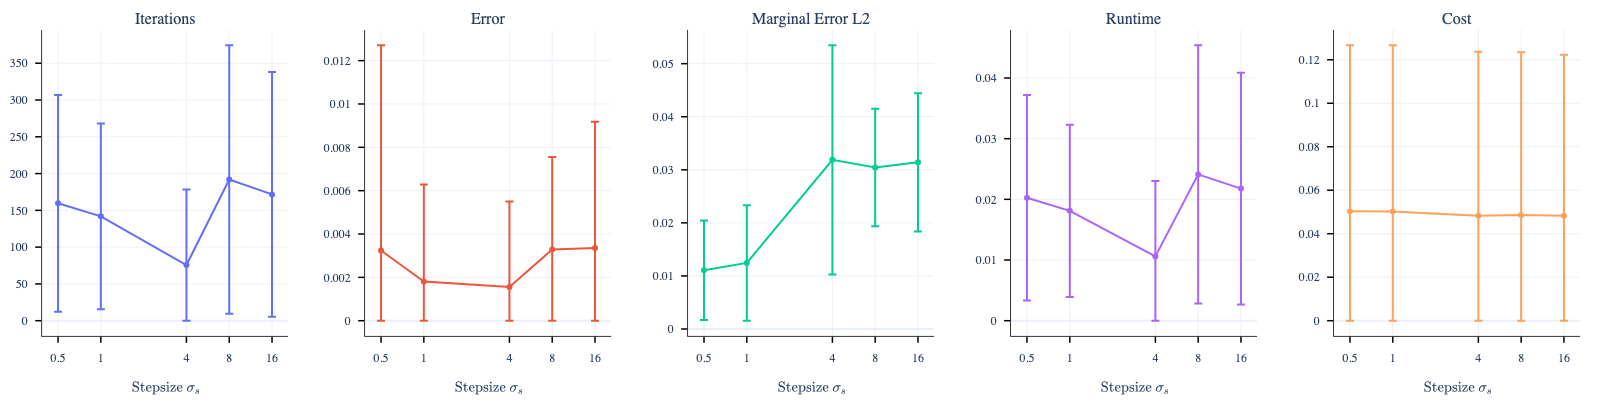

tv_mu_to_nu                         ma_residual_L1                  \
                mean     std     min     max           mean     std     min   
stepsize                                                                      
0.5           0.0261  0.0218  0.0013  0.0621         0.0321  0.0302  0.0025   
1.0           0.0286  0.0242  0.0017  0.0648         0.0417  0.0390  0.0028   
4.0           0.0627  0.0366  0.0174  0.1662         0.1145  0.0763  0.0260   
8.0           0.0608  0.0190  0.0321  0.0820         0.1133  0.0449  0.0396   
16.0          0.0628  0.0239  0.0283  0.1072         0.1154  0.0517  0.0373   

                 ma_residual_Linf          ... detJ_max         detJ_neg_frac  \
             max             mean     std  ...      min     max          mean   
stepsize                                   ...                                  
0.5       0.1140           0.0035  0.0038  ...   1.4951  8.9898        0.0391   
1.0       0.1032           0.0049  0.0048  ...   1.4951  8.7976        0.0410   
4.0       0.3287           0.0114  0.0060  ...   1.6050  6.8636        0.0384   
8.0       0.1601           0.0116  0.0047  ...   1.2322  3.2500        0.0313   
16.0      0.1921           0.0120  0.0047  ...   1.3469  2.5000        0.0332   

                              phi_is_convex                 
             std  min     max          mean  std  min  max  
stepsize                                                    
0.5       0.0622  0.0  0.2083           1.0  0.0  1.0  1.0  
1.0       0.0635  0.0  0.2083           1.0  0.0  1.0  1.0  
4.0       0.0601  0.0  0.1979           1.0  0.0  1.0  1.0  
8.0       0.0355  0.0  0.1042           1.0  0.0  1.0  1.0  
16.0      0.0441  0.0  0.1562           1.0  0.0  1.0  1.0  

[5 rows x 28 columns]

1D Monge diagnostics vs stepsize


In [53]:
successful_1d = results_1d[results_1d["status"] == "success"].copy()
print(f"Successful runs (1d): {len(successful_1d)}")
fig_1d_metrics = plot_metric_summary(successful_1d, title="")
# fig_1d_metrics = plot_metric_summary(successful_1d, title="1D Back-and-Forth metrics vs stepsize")
fig_1d_metrics.write_image("figures/1d_backnforth_metrics_vs_stepsize.png")
plot_monge_summary(successful_1d, title="1D Monge diagnostics vs stepsize")

### 1D convergence & pushforward diagnostics
The following cells replay a single 1D problem for every step size to capture the full iteration traces and transport maps.


In [11]:
problem_index_1d = 0
histories_1d = build_history_bundle(
    problems=problems_1d,
    stepsizes=stepsizes_1d,
    solver_kwargs=solver_kwargs_1d,
    problem_index=problem_index_1d,
)
len(histories_1d)


5

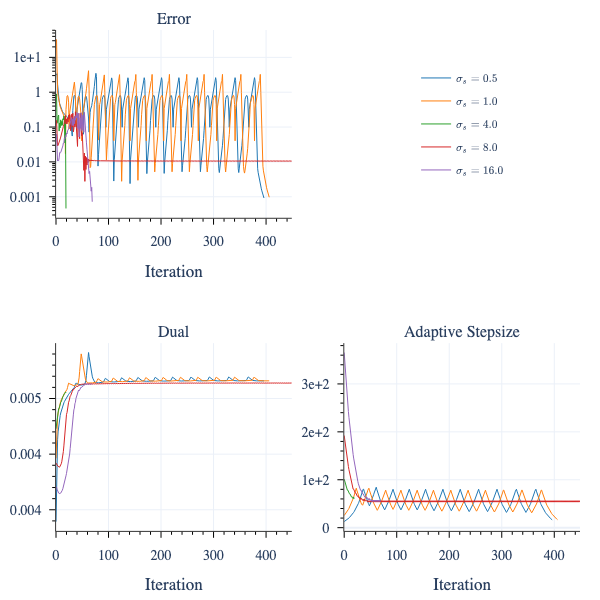

In [60]:
fig_1d_conv_history = plot_convergence_histories(histories_1d, title=f"1D problem {problem_index_1d} — convergence vs stepsize")
fig_1d_conv_history.write_image("figures/1d_backnforth_convergence_vs_stepsize.png")

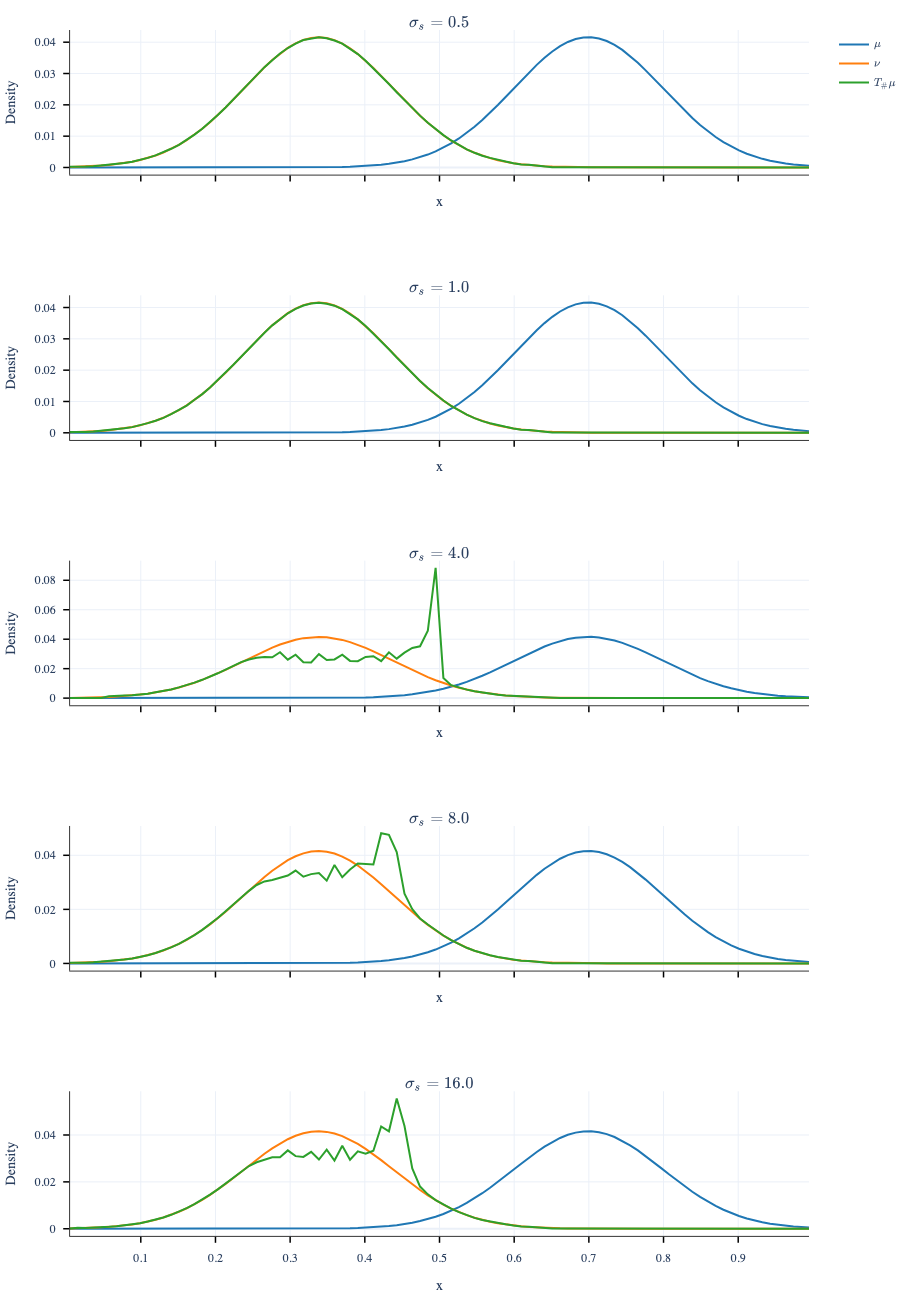

In [55]:
fig_1d_pushforwards = plot_pushforwards_1d(histories_1d, title=f"")
# fig_1d_pushforwards = plot_pushforwards_1d(histories_1d, title=f"1D problem {problem_index_1d} — pushforward densities")
fig_1d_pushforwards.write_image("figures/1d_backnforth_pushforward_densities.png")

In [14]:
monge_history_1d = pd.DataFrame([
    {
        "stepsize": hist["stepsize"],
        **hist["monge_metrics"],
    }
    for hist in histories_1d
])
monge_history_1d


,stepsize,tv_mu_to_nu,ma_residual_L1,ma_residual_Linf,detJ_min,detJ_max,detJ_neg_frac,phi_is_convex,eigenvalue_min_phi_hessian,condition_number_hessian_eigenvalues
0,0.5,0.001833,0.005633,0.000396,-3.551326e-14,1.495135,0.145833,1.0,-3.551326e-14,1.0
1,1.0,0.001768,0.004694,0.000396,-3.551326e-14,1.495088,0.145833,1.0,-3.551326e-14,1.0
2,4.0,0.166151,0.328667,0.025453,-1.572076e-13,1.605001,0.156250,1.0,-1.572076e-13,1.0
3,8.0,0.073092,0.144886,0.015248,-9.094808e-13,1.494113,0.093750,1.0,-9.094808e-13,1.0
4,16.0,0.095729,0.192085,0.018303,-1.819003e-12,1.481973,0.093750,1.0,-1.819003e-12,1.0


## 2D sweep
Repeat the analysis on 2D grids. The heavier problems use a smaller tolerance and shorter maximum iteration count to keep the runtime manageable.


In [15]:
if "results_2d" not in globals():
    results_2d, problems_2d = run_stepsize_pipeline(
        dataset_config=dataset_config_2d,
        n_problems=n_problems_2d,
        stepsizes=stepsizes_2d,
        solver_kwargs=solver_kwargs_2d,
        progress=True,
    )
else:
    print("Using cached results_2d.")
results_2d.head()


Back-and-Forth SqEuclid({'pushforward_fn': <function adaptive_pushforward_nd at 0x139fe8220>, 'maxiter': 600, 'tol': 0.001, 'stepsize': 16.0, 'error_metric': 'h1_psi_relative', 'stepsize_lower_bound': 0.01}): 100%|██████████| 60/60 [07:26<00:00,  7.44s/it]


,dataset,mu_size,nu_size,cost,monge_map,u_final,v_final,iterations,error,marginal_error_L2,...,condition_number_hessian_eigenvalues,status,problem_index,pushforward_fn,maxiter,tol,stepsize,error_metric,stepsize_lower_bound,name
0,"Gaussian (2d, 2c, 96x96)",9216,9216,0.02767015044252427,"[[[0.0, 0.12687399902441143], [0.0, 1.18994637...","[[0.04258672397382231, 0.04260049068378589, 0....","[[-0.04258672397382231, -0.042600490683785894,...",32,0.0008757527535234604,0.0017235872046058665,...,1.221463e+12,success,0,<function adaptive_pushforward_nd at 0x139fe8220>,600,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
1,"Gaussian (2d, 2c, 96x96)",9216,9216,0.14907487849932585,"[[[0.3148415175317325, 0.0], [0.33148731860794...","[[0.14530718763620745, 0.14526966149059675, 0....","[[-0.14530718763620745, -0.14526966149059675, ...",31,0.0008176655404614567,0.002697407992148255,...,4.916320e+12,success,1,<function adaptive_pushforward_nd at 0x139fe8220>,600,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
2,"Gaussian (2d, 2c, 96x96)",9216,9216,0.2773102867476704,"[[[0.0, 1.8445269187309776], [0.0, 3.659044826...","[[-0.023806816782011127, -0.023752563309788904...","[[0.023806816782011127, 0.023606672802114103, ...",39,0.00010346569641374644,0.004750905638117518,...,6.758405e+12,success,2,<function adaptive_pushforward_nd at 0x139fe8220>,600,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
3,"Gaussian (2d, 2c, 96x96)",9216,9216,0.06300384036847057,"[[[0.7184581330160391, 0.0], [0.71845813301603...","[[-0.026070033141110248, -0.02614827119607675,...","[[0.026070033141110248, 0.02612428661333247, 0...",30,0.0009360434734191105,0.002096582217389985,...,3.590267e+12,success,3,<function adaptive_pushforward_nd at 0x139fe8220>,600,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid
4,"Gaussian (2d, 2c, 96x96)",9216,9216,0.0746496873768599,"[[[0.0, 0.05667485429425412], [0.0, 1.08475552...","[[-0.02909289022371368, -0.029086740608447376,...","[[0.02909289022371368, 0.029086740608447376, 0...",37,0.0008501210388084755,0.0031384416709374944,...,1.731885e+13,success,4,<function adaptive_pushforward_nd at 0x139fe8220>,600,0.001,0.5,h1_psi_relative,0.01,Back-and-Forth SqEuclid


Successful runs (2d): 60


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_23267/1433512176.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_

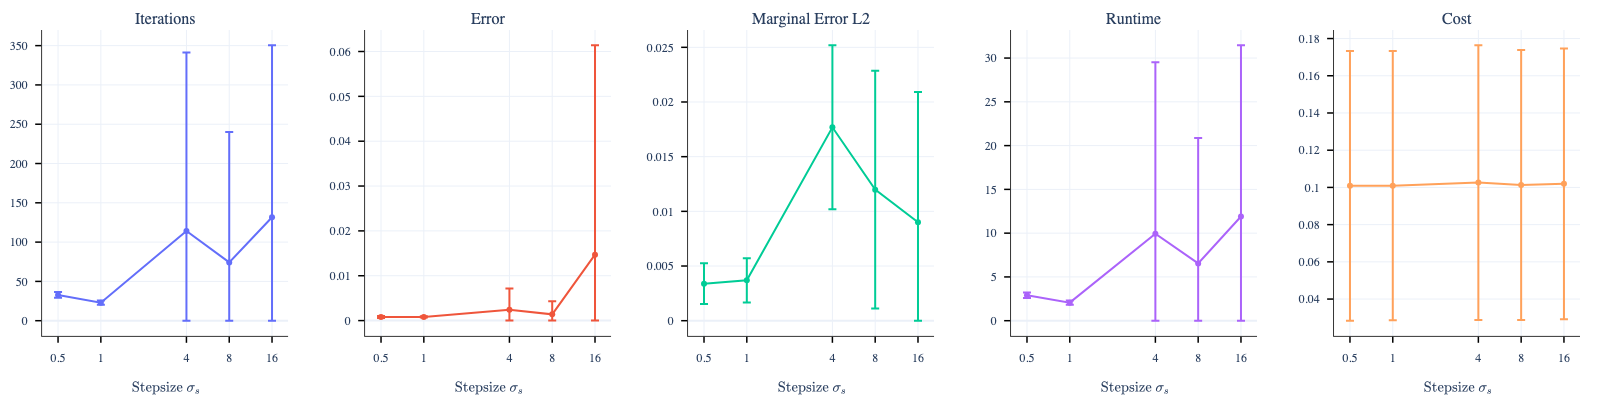

tv_mu_to_nu                         ma_residual_L1                  \
                mean     std     min     max           mean     std     min   
stepsize                                                                      
0.5           0.0641  0.0215  0.0411  0.1188         0.2089  0.1092  0.1191   
1.0           0.0662  0.0228  0.0410  0.1238         0.2123  0.1093  0.1218   
4.0           0.2484  0.1196  0.0926  0.4940         0.5567  0.2440  0.2255   
8.0           0.1636  0.1586  0.0537  0.6257         0.3965  0.3883  0.1272   
16.0          0.1315  0.1873  0.0249  0.7033         0.3393  0.4523  0.0889   

                 ma_residual_Linf          ... detJ_max            \
             max             mean     std  ...      min       max   
stepsize                                   ...                      
0.5       0.5078           0.0013  0.0012  ...  16.6656  187.8594   
1.0       0.5118           0.0013  0.0012  ...  17.9142  178.1803   
4.0       1.0058           0.0040  0.0026  ...  18.7554  121.4424   
8.0       1.5557           0.0089  0.0231  ...  17.0108  121.2760   
16.0      1.7378           0.0073  0.0196  ...  14.4438  134.5571   

         detJ_neg_frac                         phi_is_convex                  \
                  mean     std     min     max          mean     std     min   
stepsize                                                                       
0.5             0.0777  0.0581  0.0176  0.1921        0.9816  0.0208  0.9384   
1.0             0.0798  0.0567  0.0195  0.1913        0.9802  0.0209  0.9353   
4.0             0.1133  0.0756  0.0258  0.2604        0.9696  0.0281  0.9100   
8.0             0.1339  0.0868  0.0357  0.3315        0.9688  0.0280  0.9163   
16.0            0.1554  0.0725  0.0489  0.3304        0.9672  0.0300  0.8814   

                  
             max  
stepsize          
0.5       0.9995  
1.0       0.9989  
4.0       0.9944  
8.0       0.9982  
16.0      0.9964  

[5 rows x 28 columns]

2D Monge diagnostics vs stepsize


In [56]:
successful_2d = results_2d[results_2d["status"] == "success"].copy()
print(f"Successful runs (2d): {len(successful_2d)}")
fig_2d_metrics = plot_metric_summary(successful_2d, title="")
# fig_2d_metrics = plot_metric_summary(successful_2d, title="2D Back-and-Forth metrics vs stepsize")
fig_2d_metrics.write_image("figures/2d_backnforth_metrics_vs_stepsize.png")
plot_monge_summary(successful_2d, title="2D Monge diagnostics vs stepsize")


### 2D convergence & pushforward diagnostics


In [17]:
problem_index_2d = 1
histories_2d = build_history_bundle(
    problems=problems_2d,
    stepsizes=stepsizes_2d,
    solver_kwargs=solver_kwargs_2d,
    problem_index=problem_index_2d,
)
len(histories_2d)


5

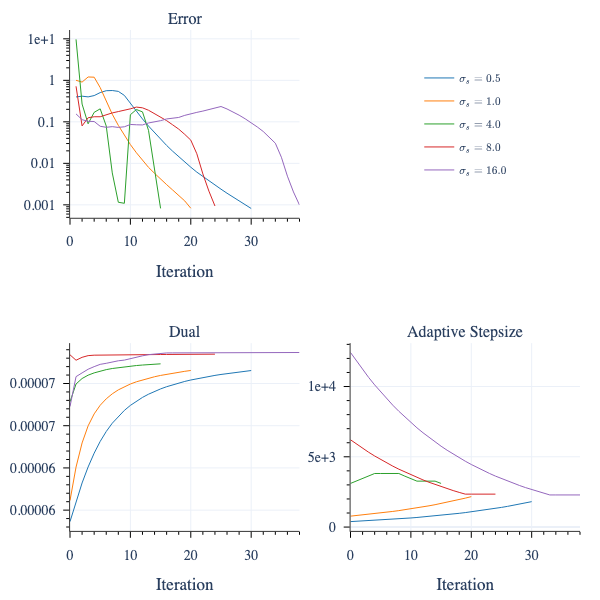

In [61]:
fig_2d_conv_history = plot_convergence_histories(histories_2d, title=f"2D problem {problem_index_2d} — convergence vs stepsize")
fig_2d_conv_history.write_image("figures/2d_backnforth_convergence_vs_stepsize.png")

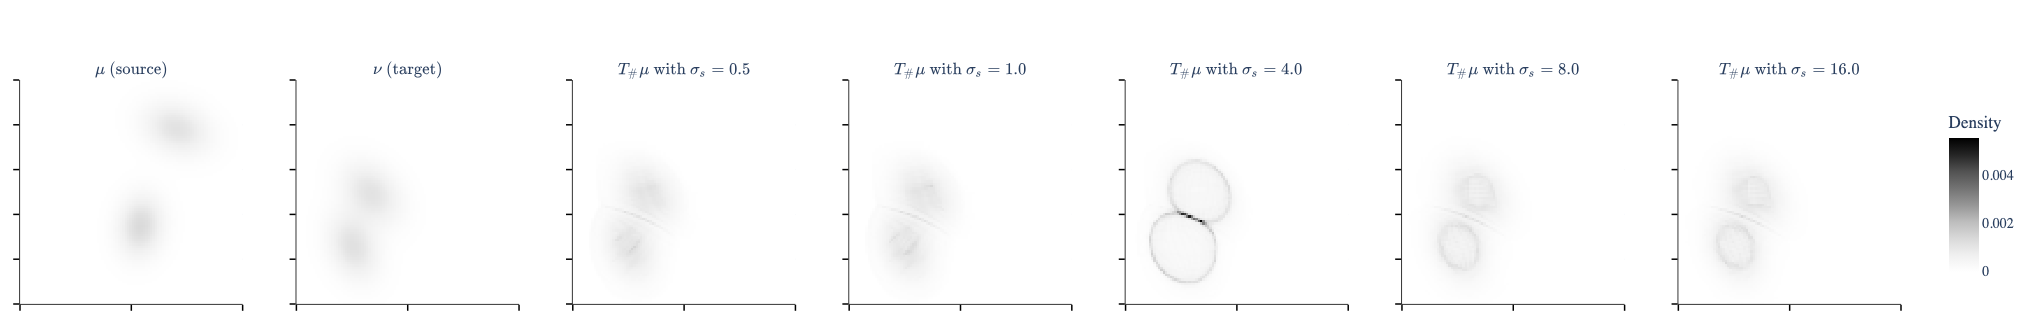

In [95]:
fig_2d_pushforwards = plot_pushforwards_2d(histories_2d, title="")
fig_2d_pushforwards.write_image("figures/2d_backnforth_pushforward_heatmaps.png")
# plot_pushforwards_2d(histories_2d, title=f"2D problem {problem_index_2d} — pushforward heatmaps")


In [20]:
monge_history_2d = pd.DataFrame([
    {
        "stepsize": hist["stepsize"],
        **hist["monge_metrics"],
    }
    for hist in histories_2d
])
monge_history_2d


,stepsize,tv_mu_to_nu,ma_residual_L1,ma_residual_Linf,detJ_min,detJ_max,detJ_neg_frac,phi_is_convex,eigenvalue_min_phi_hessian,condition_number_hessian_eigenvalues
0,0.5,0.055063,0.155239,0.000553,-0.209633,56.623200,0.094944,0.965603,-0.165209,4.916320e+12
1,1.0,0.060120,0.164060,0.000621,-0.192643,70.938558,0.097222,0.963976,-0.158814,5.078404e+12
2,4.0,0.323245,0.673722,0.003936,-0.476674,64.095429,0.131185,0.949219,-0.228287,5.153746e+12
3,8.0,0.089257,0.215123,0.001552,-1.999227,105.141019,0.159397,0.944119,-0.518134,6.401395e+12
4,16.0,0.077584,0.190280,0.001426,-6.222481,42.321013,0.159505,0.968207,-1.084205,8.338285e+12
